Project: Astro
==============

This example uses the astrophysical phenomena of Strong Gravitational Lensing to illustrate basic and advanced model
composition and fitting with **PyAutoFit**. The first tutorial described what a strong gravitational lens is and how
we build and fit a model of one.

In this example, we use **PyAutoFit**'s graphical models to compose a strong lens model consisting of a lens and
source galaxy, and fit it to the data on SDSSJ2303+1422.

__Config Path__

We first set up the path to this projects config files, which is located at `autofit_workspace/projects/astro/config`.

This includes the default priors for the lens model, check it out!

In [2]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import src as astro
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Jammy\Code\PyAuto\autofit_skies
Working Directory has been set to `C:\Users\Jammy\Code\PyAuto\autofit_skies`


__Plot__

First, lets again define the plotting convenience functions we used in the previous example.

In [3]:
def plot_array(array, title=None, norm=None):

    plt.imshow(array, norm=norm)
    plt.colorbar()
    plt.title(title)
    plt.show()
    plt.close()

def plot_grid(grid, title=None):

    plt.scatter(x=grid[:, :, 0], y=grid[:, :, 1], s=1)
    plt.title(title)
    plt.show()
    plt.close()

__Data__

Now lets load and plot Hubble Space Telescope imaging data of the strong gravitational lens SDSSJ2303+1422.

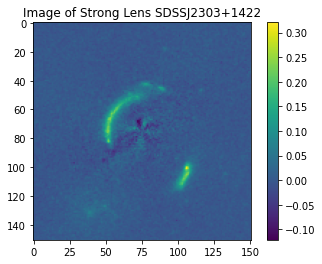

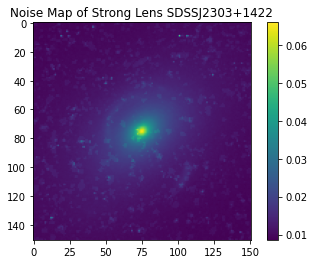

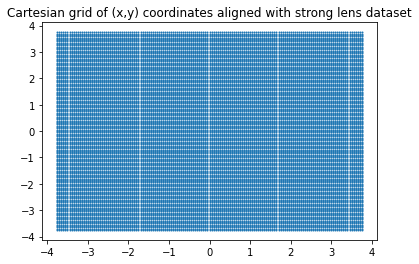

In [4]:
dataset_path = path.join("dataset", "slacs2303+1422")

image = np.load(file=path.join(dataset_path, "image.npy"))
noise_map = np.load(file=path.join(dataset_path, "noise_map.npy"))

plot_array(array=image, title="Image of Strong Lens SDSSJ2303+1422")
plot_array(array=noise_map, title="Noise Map of Strong Lens SDSSJ2303+1422")

grid = np.load(file=path.join(dataset_path, "grid.npy"))

plot_grid(grid=grid, title="Cartesian grid of (x,y) coordinates aligned with strong lens dataset")

__Graphical Model__

In the previous example, we saw that we can use instances of the light profiles, mass profiles and galaxy objects to
perform strong lens ray-tracing calculations:

In [5]:
light_profile = astro.lp.LightDeVaucouleurs(
    centre=(0.01, 0.01),
    axis_ratio=0.7,
    angle=45.0,
    intensity=1.0,
    radius=2.0
)

mass_profile = astro.mp.MassIsothermal(
    centre=(0.01, 0.01),
    axis_ratio=0.7,
    angle=45.0,
    mass=0.5
)

lens_galaxy = astro.Galaxy(
    redshift=0.5,
    light_profiles=[light_profile],
    mass_profiles=[mass_profile]
)

galaxy_image = lens_galaxy.image_from_grid(grid=grid)

plot_array(array=galaxy_image, title="Image of the Lens Galaxy.")

In this example, we want to perform a model-fit using a non-linear search, where the `Galaxy` is a `Model`, but it
contains model subcomponents that are its individual light and mass profiles. Here is a pictoral representation of
the model:

![Strong Lens Model](https://github.com/rhayes777/PyAutoFit/blob/master/docs/overview/image/lens_model.png?raw=true "cluster")

__Model Composition__

How do we compose a strong lens model where a `Galaxy` is a `Model`, but it contains the light and mass profiles
as `Model` themselves?

We use **PyAutoFit**'s graphical model composition:

In [ ]:
light_model = af.Model(astro.lp.LightDeVaucouleurs)
mass_model = af.Model(astro.mp.MassIsothermal)

lens = af.Model(
    cls=astro.Galaxy, # The overall model object uses this input.
    redshift=0.5,
    light_profiles=[light_model], # These will be sub-components of the model.
    mass_profiles=[mass_model] # These will be sub-components of the model.
)

Lets consider what is going on here:

 1) We use a `Model` to create the overall model component. The `cls` input is the `Galaxy` class, therefore the 
 overall model that is created is a `Galaxy`.
  
 2) **PyAutoFit** next inspects whether the key word argument inputs to the `Model` match any of the `__init__` 
constructor arguments of the `Galaxy` class. This determine if these inputs are to be composed as model sub-components. 

 3) **PyAutoFit** matches the `light_profiles` and  `mass_profiles` inputs, noting they are passed as separate lists 
 containing the `LightDeVaucouleurs` and `MassIsothermal` class. They are created as sub-components of the overall
 `Galaxy` model.
  
 4) It also matches the `redshift` input, making it a fixed value of 0.5 for the model and not treating it as a 
 free parameter.
 
We can confirm this by printing the `prior_count` of the lens, and noting it is 11 (6 parameters for 
the `LightDeVaucouleurs` and 5 for the `MassIsothermal`).

In [7]:
print(lens.prior_count)
print(lens.light_profiles[0].prior_count)
print(lens.mass_profiles[0].prior_count)

11
6
5


The `lens` behaves exactly like the model-components we are used to previously. For example, we can unpack its 
individual parameters to customize the model, where below we:

 1) Align the light profile centre and mass profile centre.
 2) Customize the prior on the light profile `axis_ratio`.
 3) Fix the `axis_ratio` of the mass profile to 0.8.

In [8]:
lens.light_profiles[0].centre = lens.mass_profiles[0].centre
lens.light_profiles[0].axis_ratio = af.UniformPrior(lower_limit=0.7, upper_limit=0.9)
lens.mass_profiles[0].axis_ratio = 0.8

print(lens)

Galaxy (centre_0, GaussianPrior, mean = 0.0, sigma = 0.1), (centre_1, GaussianPrior, mean = 0.0, sigma = 0.1), (axis_ratio, UniformPrior, lower_limit = 0.7, upper_limit = 0.9), (angle, UniformPrior, lower_limit = 0.0, upper_limit = 180.0), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (radius, UniformPrior, lower_limit = 0.0, upper_limit = 30.0), (centre_0, GaussianPrior, mean = 0.0, sigma = 0.1), (centre_1, GaussianPrior, mean = 0.0, sigma = 0.1), (angle, UniformPrior, lower_limit = 0.0, upper_limit = 180.0), (mass, UniformPrior, lower_limit = 0.0, upper_limit = 8.0)


We can create the `Galaxy` model component with the exact same customization by creating each profile as a `Model` and
passing these to the galaxy `Model`. 

In [ ]:
light = af.Model(astro.lp.LightDeVaucouleurs)
mass = af.Model(astro.mp.MassIsothermal)

light.centre = mass.centre
light.axis_ratio = af.UniformPrior(lower_limit=0.7, upper_limit=0.9)
mass.axis_ratio = 0.8

lens = af.Model(
    astro.Galaxy,
    redshift=0.5,
    light_profiles=[light],
    mass_profiles=[mass]
)

print(lens)

Which API is better for creating a model component? It depends on the modeling problem! Therefore having a handle of
both methods is useful in different situations.

We can now create a model of our source galaxy using the same API.

In [11]:
source = af.Model(
    astro.Galaxy,
    redshift=1.0,
    light_profiles=[af.Model(astro.lp.LightExponential)]
)

print(source)

Galaxy (centre_0, GaussianPrior, mean = 0.0, sigma = 0.3), (centre_1, GaussianPrior, mean = 0.0, sigma = 0.3), (axis_ratio, UniformPrior, lower_limit = 0.2, upper_limit = 1.0), (angle, UniformPrior, lower_limit = 0.0, upper_limit = 180.0), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (radius, UniformPrior, lower_limit = 0.0, upper_limit = 30.0)


We can now create our overall strong lens model, using a `Collection` in the same way we have seen previously.

In [14]:

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

print(model)

Galaxy (centre_0, GaussianPrior, mean = 0.0, sigma = 0.1), (centre_1, GaussianPrior, mean = 0.0, sigma = 0.1), (axis_ratio, UniformPrior, lower_limit = 0.7, upper_limit = 0.9), (angle, UniformPrior, lower_limit = 0.0, upper_limit = 180.0), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (radius, UniformPrior, lower_limit = 0.0, upper_limit = 30.0), (centre_0, GaussianPrior, mean = 0.0, sigma = 0.1), (centre_1, GaussianPrior, mean = 0.0, sigma = 0.1), (angle, UniformPrior, lower_limit = 0.0, upper_limit = 180.0), (mass, UniformPrior, lower_limit = 0.0, upper_limit = 8.0), Galaxy (centre_0, GaussianPrior, mean = 0.0, sigma = 0.3), (centre_1, GaussianPrior, mean = 0.0, sigma = 0.3), (axis_ratio, UniformPrior, lower_limit = 0.2, upper_limit = 1.0), (angle, UniformPrior, lower_limit = 0.0, upper_limit = 180.0), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (radius, UniformPrior, lower_limit = 0.0, upper_limit = 30.0)


The model contains both galaxies in the strong lens, alongside all of their light and mass profiles.

For every iteration of the non-linear search **PyAutoFit** generates an instance of this model, where all of the
`LightDeVaucouleurs`, `MassIsothermal` and `Galaxy` parameters of the are determined via their priors. 

An example instance is show below:

In [15]:
instance = model.instance_from_prior_medians()

print("Strong Lens Model Instance:")
print("Lens Galaxy = ", instance.galaxies.lens)
print("Lens Galaxy Bulge = ", instance.galaxies.lens.light_profiles)
print("Lens Galaxy Bulge Centre = ", instance.galaxies.lens.light_profiles[0].centre)
print("Lens Galaxy Mass Centre = ", instance.galaxies.lens.mass_profiles[0].centre)
print("Source Galaxy = ", instance.galaxies.source)

Strong Lens Model Instance:
Lens Galaxy =  <src.galaxy.Galaxy object at 0x00000195B1F2C970>
Lens Galaxy Bulge =  <autofit.mapper.model.ModelInstance object at 0x00000195B1F2CD30>
Lens Galaxy Bulge Centre =  (0.0, 0.0)
Lens Galaxy Mass Centre =  (0.0, 0.0)
Source Galaxy =  <src.galaxy.Galaxy object at 0x00000195B1F2AE20>


We have successfully composed a graphical model, which we can fit via a non-linear search.

At this point, you should check out the `Analysis` class of this example project, in the 
module `projects/astro/src/analysis.py`. This class serves the same purpose that we have seen in the Gaussian 1D 
examples, with the `log_likelihood_function` implementing the calculation we showed in the first tutorial.

In [16]:

search = af.DynestyStatic(
   path_prefix=path.join("projects", "astro"),
   name="graphical",
   nlive=50,
)

analysis = astro.Analysis(image=image, noise_map=noise_map, grid=grid)

If you comment out the code below, you will perform a lens model fit using the model and analysis class for 
this project. However, this model-fit is fairly slow to run, and it isn't paramount that you run it yourself.

The animation below shows a slide-show of the lens modeling procedure. Many lens models are fitted to the data over
and over, gradually improving the quality of the fit to the data and looking more and more like the observed image.

![Lens Modeling Animation](https://github.com/Jammy2211/auto_files/blob/main/lensmodel.gif?raw=true "model")

In [17]:

# result = search.fit(model=model, analysis=analysis)

__Extensibility__

This example project highlights how graphical models can make certain model-fitting problem fully extensible. For
example:

 1) A `Galaxy` class can be created using any combination of light and mass profiles, because it can wrap their
 `image_from_grid` and `deflections_from_grid` methods as the sum of the individual profiles.
 
 2) The overall strong lens model can contain any number of `Galaxy`'s, as these methods and their redshifts are used 
 to implement the lensing calculations in the `Analysis` class and `log_likelihood_function`.
 
Thus, for problems of this nature, we can design and write code in a way that fully utilizes **PyAutoFit**'s graphical
modeling features to compose and fits models of arbitrary complexity and dimensionality. 

To illustrate this further, consider the following dataset which is called a *strong lens galaxy cluster*:

![Strong Lens Cluster](https://github.com/rhayes777/PyAutoFit/blob/master/docs/overview/image/cluster_example.jpg?raw=true "cluster")

For this strong lens, there are many tens of strong lens galaxies as well as multiple background source galaxies. 
However, despite it being a significantly more complex system than the single-galaxy strong lens we modeled above,
our use of graphical models ensures that we can model such datasets without any additional code development, for
example:

In [ ]:
lens_0 = af.Model(
    astro.Galaxy,
    redshift=0.5,
    light_profiles=[astro.lp.LightDeVaucouleurs],
    mass_profiles=[astro.mp.MassIsothermal]
)

lens_1 = af.Model(
    astro.Galaxy,
    redshift=0.5,
    light_profiles=[astro.lp.LightDeVaucouleurs],
    mass_profiles=[astro.mp.MassIsothermal]
)

source_0 = af.Model(
    astro.Galaxy,
    redshift=1.0,
    light_profiles=[af.Model(astro.lp.LightExponential)]
)

# ... repeat for desired model complexity ...

model = af.Collection(
    galaxies=af.Collection(
        lens_0=lens_0,
        lens_1=lens_1,
        source_0=source_0,
        # ... repeat for desired model complexity ...
    )
)

Here is a pictoral representation of a strong lens cluster as a graphical model:

![Strong Lens Cluster Model](https://github.com/rhayes777/PyAutoFit/blob/master/docs/overview/image/lens_model_cluster.png?raw=true "cluster")

__Wrap Up__

Strong gravitational lensing is a great example of a problem that can be approached using graphical models.

At the core of this is how there are many different models one could imagine defining which describe the light or mass 
of a galaxy. However, all of these models must derive the same fundamental property in order to fit the data, for
example the image of a light profile or the deflection angles of the mass profile.